# Riduzione della dimensionalità

Nella parte precedente si è parlato di selezione delle caratteristiche ora si proverà a condensare le informazioni del dataset andando a trasformarlo in un nuovo sottospazio con caratterestiche di dimensionalità inferiore.

In questa parte del corso andremo ad analizzare le seguenti tecniche:
* PCA *Principal Component Analisys* per la compressione dei dati senza supervisione
* LDA *Linear Discriminant* per per la riduzione di dimensionalità con supervisione
* KPCA *Kernel Principal Analisys* per la riduzione di dimensionalità non lineare

## Riduzione di dimensionalità senza supervisione (PCA)
Nella lezione precedente abbiamo visto come ridurre il numero di feature utilizzando vari algoritmi di selezione, ora invece parliamo di **estrazione** delle caratteristiche puo essere considerato come un approccio di compressione dei dati con l'obiettivo di conservare la maggior parte delle informazioni rilevanti e di combattere la *maledizione delle dimensionalità*. 

L'analisi *PCA* è una tecnica di trasformazione lineare non supervisionata, di solito questa tecnica viene usata per eliminare il rumore nei dati, questa tipo di analisi aiuta ad identificare gli schemi presenti nei dati sulla base delle correlazioni tra le varie caratteristiche. 

In estrema sistesi l'analisi mira a trovare le dimensioni di massima varianza all'interno dei dati per poi proiettarli in uno spazio avente dimensione minore o uguale. I nuovi assi ortogonali (le componenti principali) del nuovo spazio possono essere interpretate come le direzioni di massima varianza sapendo che essi saranno ortogonali.

 ![pca](./images/pca.png)

Per eseguire questa trasformazione si costruisce una matrice $d \times k$ con d il numero delle feature e k un numero minore o uguale a d a nostra scelta. Ovviamente il risultato sarà un nuovo dataset con k features, la prima componente sarà la dimensione con la massima varianza e a seguire tutte le altre. Si parte da un concetto che le componenti sono slegate in quanto i le k features sono ortogonali.

Come prima cosa si nota subito che l'analisi PCA è molto sensibile alle differenze di scala perciò dovremo dare la stessa importanza a tutte le caratteristiche.

Questa analisi si può riassumere con questi passi:

* Standardizzare il dataset a d dimensioni
* Costruire la matrice di covarianza
* Decomporre la matrice di covarianza nei suoi autovettori e autovalori
* Selezionare i k autovettori con i valori più grandi
* Costruire la matrice **W** partendo dai k autovettori
* Trasformare il dataset a d dimensioni X utilizzando la matrice di proiezione **W** per ottenere il nuovo sottospazio k dimensionale 


## Varianza totale e spiegata
Cominciamo ad analizzare i primi quattro passi descritti prima. 
Cominciamo subito con il caricare il dataset wine già visto in precedenza.

In [1]:
from sklearn.datasets import load_wine
wine = load_wine()

dividiamo il dataset in due insiemi distinti (train e test) e li standardizziamo in modo da avere tutti i dati sulla stessa scala

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train,X_test,y_train,y_test = train_test_split(wine.data,wine.target,test_size = 0.3,random_state=0)
sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

dopo questo passo di pre elaborazione si passa al calcolo della matrice di covarianza. Questa è una matrice simmetrica di dimensione $d \times d$ e misura la covarianza tra le coppie delle varie caratteristiche ad esempio la covarianza tra le features $x_j$ e $x_k$ può essere espressa con la formula:

$$\sigma_{jk} = \frac{1}{n} \sum_{i=1}^{n} \left(x^{i}_j - \mu_j \right) \left(x^{i}_k - \mu_k \right)$$

I valori $\mu_j$ e $\mu_k$ sono le medie della caratteristica j e k. una osservazione se standardizziamo il dataset le medie del campione valgono 0. Un valore di covarianza positivo indica che esse aumentano o si riducono assieme, se il valore invece è negativo questo sta ad indicare che le misure variano ma in direzione opposte.

<AxesSubplot:>

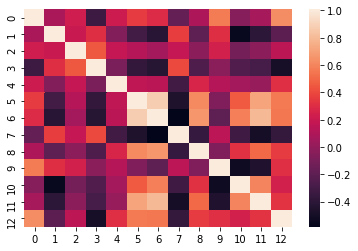

In [3]:
import numpy as np
import seaborn as sns

cov_mat = np.cov(X_train_std.T)
sns.heatmap(cov_mat)

Gli autovettori della matrice di covarianza rappresentano le componenti principali (sono le direzioni di massima varianza), mentre i corrispondenti autovalori rappresentano la loro ampiezza. 
Andiamo a calcolare le coppie di autovettori e autovalori.

In [4]:
eigen_vals,eigen_vects = np.linalg.eig(cov_mat)

print(eigen_vals)

[4.8923083  2.46635032 1.42809973 1.01233462 0.84906459 0.60181514
 0.52251546 0.08414846 0.33051429 0.29595018 0.16831254 0.21432212
 0.2399553 ]


La funzione ``eig`` esegue la scomposizione della matrice e restituisce nel nostro caso un vettore costituito da 13 valori e una matrice 13x13 dove ogni riga rappresenta un autovettore. Ora visto che vogliamo ridurre il nostro dataset comprimendolo in un sottospazio, selezioneremo solo l'insieme degli autovettori che contengono la maggior parte delle informazioni.

Facciamo anche un calcolo semplice che indica il rapporto di *varianza spiegata* tra i vari autovettori esso non è altro che il rapporto tra l'autovalore e la somma di tutti gli autovalori.

$$\frac{\lambda_j}{ \sum_{i=1}^{d} \lambda_i}$$

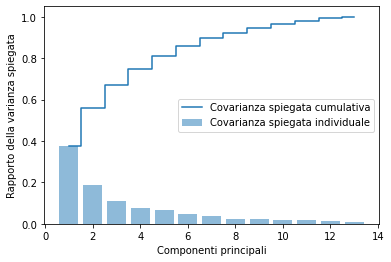

In [5]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals,reverse = True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1,14), var_exp,alpha=0.5,align='center',label='Covarianza spiegata individuale')
plt.step(range(1,14), cum_var_exp,where='mid',label='Covarianza spiegata cumulativa')
plt.ylabel('Rapporto della varianza spiegata')
plt.xlabel('Componenti principali')
plt.legend(loc='best')
plt.show()

In [6]:
print("Covarianza cumulativa delle componenti {0:.2f}".format(cum_var_exp[1]))

Covarianza cumulativa delle componenti 0.56


come si vede dal codice sopra già le prime due features rappresentano il quasi il 60% della varianza presente nei dati.
Ora questo grafico parla dell'importanza delle varie features, dobbiamo ricordarci però che a differenza dei metodi visti nella lezione precedente, questa è una metodologia senza supervisione.

## Trasformazione di una caratteristica
Eseguiamo ora gli ultimi tre passi descritti prima, costruiamo la matrice di trasformazione **w** andando ad ordinare i valori degli autovalori ed estrarre i corrispettivi autovettori. 
Estraiamo solo due caratteristiche per visualizzare il comportamento dell'algoritmo più avanti

In [7]:
eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vects[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key = lambda k:k[0],reverse = True)

In [8]:
w = np.hstack((
    eigen_pairs[0][1][:,np.newaxis],
    eigen_pairs[1][1][:,np.newaxis]))

print(w)

[[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


tramite il codice precedente abbiamo creato una matrice 13x2 con gli autovettori che rappresentano la maggior varianza dei dati, ora andiamo a proiettare un elemento del dataset nel nuovo sottospazio eseguendo la seguente trasformazione:

$$x^{'} = x \cdot w$$

In [9]:
X_train_std[0].dot(w)

array([2.59891628, 0.00484089])

possiamo eseguire lo stesso passaggio per tutto il dataset

In [10]:
X_train_pca = X_train_std.dot(w)
X_train_pca.shape

(124, 2)

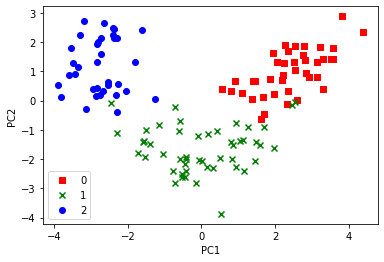

In [11]:
colors = ["r","g","b"]
markers = ["s","x","o"]

for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_pca[y_train == l,0],X_train_pca[y_train == l,1],c=c,label=l,marker=m)
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')

I passi che abbiamo visto prima servivano soltanto per spiegare il funzionamento interno dell'algoritmo PCA andiamo ora ad utilizzare i metodi messi a disposizione da sklearn

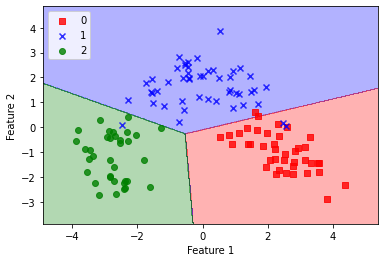

In [12]:
from libs import dataset
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression()

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca,y_train)

dataset.plot_decision_region(X_train_pca,y_train,lr)

per completezza vediamo anche il comportamento della regressione logistica anche sul dataset di test

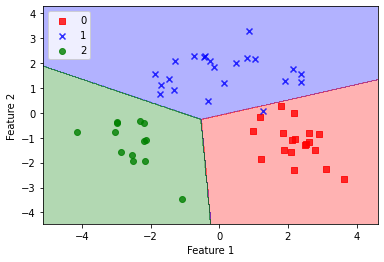

In [13]:
dataset.plot_decision_region(X_test_pca,y_test,lr)

per ottenere i valori della varianza spiegata basta semplicemente utilizzare la classe PCA con il parametro ``n_components`` impostato a ``None`` in modo da mantenere tutte le componenti

In [14]:
pca = PCA(n_components=None)
pca.fit_transform(X_train_std)

pca.explained_variance_ratio_

array([0.37329648, 0.18818926, 0.10896791, 0.07724389, 0.06478595,
       0.04592014, 0.03986936, 0.02521914, 0.02258181, 0.01830924,
       0.01635336, 0.01284271, 0.00642076])

## Compressione dei dati con supervisione (LDA)

L'analisi LDA è molto simile alla precedente tecnica tranne per il fatto che la tecnica PCA cerca di trovare di trovare degli assi ortogonali sulle componenti con la massima varianza del dato mentre l'obiettivo della LDA è quello di tovare un sottospazio delle caratteritiche che ottimizza la separabilità delle classi. 

Entrambe sono tecniche di trasformazione lineare PCA è un algoritmo non supervisionato metre LDA usa la colonna target, perciò è un sistema supervisionato.

Si potrebbe pensare che la tecnica LDA sia superiore alla PCA ma non è sempre così.

L'immagine qui sotto mostra i concetti basi di LDA per un problema a due classi i campioni della classe 1 sono identificati da un segno + mentre per quelli negativi abbiamo un segno -.

Un ottimo discriminante potrebbe essere LD1 e separerebbe bene le classi con distribuzione normale. Ma il discriminante dell'asse y (LD2) cattura molta più varianza anche se non fornisce nessuna informazione su come separare il dataset.
![lda](./images/lda.png)

Una assunzione base per il funzionamento di LDA è che i dati siano distribuiti in modo uniforme, inoltre si suppone che le classi abbiano matrici di covarianza uguali e che le caratteristiche siano indipendenti l'una dall'altra.

Se però anche queste supposizioni siano leggermente violate, questa analisi funzionerebbe ancora.
Analizziamo i passi da seguire:

* Standardizzare il dataset con d il numero delle feature
* Per ogni classe calcolare il vettore delle medie con dimensione d
* Costruire la matrice a dispersione fra le classi $S_b$ e la matrice di dispersione all'interno della classe $S_w$
* Calcolare gli autovettori e autovalori della matrice $S^{-1}_wS_b$
* Scegliere i k autovettori con valore più grande e costruire la matrice di trasformazione $d \times k$ 
* Proiettare i campioni nel nuovo sottospazio utilizzando la matrice calcolata prima

### Calcolo delle matrici di dispersione
Procediamo come prima nell'esecuzione dei passi elencati prima utilizzando il dataset wine, abbiamo già fatto prima la normalizzazione perciò passiamo subito al passo 2.
Calcoliamo il vettore delle medie per ogni classe

In [15]:
mean_vecs = []

for label in range(0,3):
    mean_vecs.append(np.mean(X_train_std[y_train == label],axis=0))

Utilizzando il vettore delle medie possiamo calcolare la matrice di dispersione all'interno della classe, $S_w$

$$S_w = \sum_{i=1}^{c}S_i$$

Il valore $S_i$ viene calcolato con la seguente formula:

$$S_i = \sum_{x \in D_i}^{c}(x-m_i)(x-m_i)^{T}$$

In [16]:
d = X_train_std.shape[1]

Sw = np.zeros((d,d))
for label,mv in zip(range(0,3),mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train == label]:
        row,mv = row.reshape(d,1),mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
    Sw += class_scatter

print("Sw dimensions {0}x{1}".format(Sw.shape[0],Sw.shape[1]))

Sw dimensions 13x13


analizziamo la distribuzione delle classi:

In [17]:
label_distribution = np.bincount(y_train)

print(label_distribution)

[40 49 35]


Anche le classi non sono uniformemente distribuite non ci dovrebbero essere problemi nel calcolo, per ovviare a questo problema dividiamo il valore calcolato prima con il numero di elementi appartenenti alla classe. Il che equivale al calcolo della matrice di covarianza.

In [18]:
d = X_train_std.shape[1]

Sw = np.zeros((d,d))
for label in zip(range(0,3)):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    Sw += class_scatter

print("Sw dimensions {0}x{1}".format(Sw.shape[0],Sw.shape[1]))

Sw dimensions 13x13


Calcoliamo ora la matrice di dispersione delle classi $S_b$ mediamente la seguente formula: $$S_b = \sum_{i=1}^{c}N_i(m_i-m)(m_i-m)^{T}$$ Qui il simbolo m indica la media generale

In [19]:
mean_overall = np.mean(X_train_std,axis=0)
d = X_train_std.shape[1]

mean_overall.reshape(d,1)

Sb = np.zeros((d,d))
for i,mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    Sb += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
    
print("Sb dimensions {0}x{1}".format(Sb.shape[0],Sb.shape[1]))


Sb dimensions 13x13


Siamo giunti ora al calcolo della matrice $S^{-1}_wS_b$ e alla decomposizione in autovalori

In [20]:
eigen_vals,eigen_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

In [21]:
eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]

eigen_pairs = sorted(eigen_pairs,key = lambda k:k[0], reverse=True)

print("Eigenvalues in descreasing order:")

for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descreasing order:
5885.380556184665
2033.672695853804
1.2809522040654087e-12
5.271223528771601e-13
4.547473508864641e-13
2.6320306275147864e-13
2.6320306275147864e-13
2.520158798769191e-13
2.2008027310072504e-13
1.5019508274698062e-13
1.5019508274698062e-13
9.637816489703847e-14
2.977811128542957e-14


Nell'analisi LDA il numero di discriminanti è al più c-1, con c il numero delle classi.
Catturiamo quanta informazione viene catturata nello stesso del metodo PCA

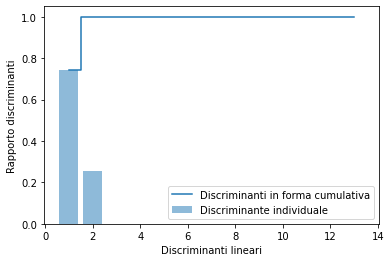

In [22]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real,reverse = True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1,14), discr,alpha=0.5,align='center',label='Discriminante individuale')
plt.step(range(1,14), cum_discr,where='mid',label='Discriminanti in forma cumulativa')
plt.ylabel('Rapporto discriminanti')
plt.xlabel('Discriminanti lineari')
plt.legend(loc='best')
plt.show()


Creiamo ora con le due colonne di autovettori la matrice di trasformazione W:

In [23]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real,
              eigen_pairs[1][1][:,np.newaxis].real))

print('Matrix W \n', w)

Matrix W 
 [[-0.06615877 -0.37974125]
 [ 0.03862056 -0.22064303]
 [-0.0217454  -0.3816223 ]
 [ 0.18400808  0.30175689]
 [-0.00343355  0.01414971]
 [ 0.23263171  0.02337798]
 [-0.77466862  0.18689504]
 [-0.08114771  0.06961935]
 [ 0.08750287  0.17958558]
 [ 0.18500646 -0.28397654]
 [-0.06595992  0.23490757]
 [-0.38052382  0.07295849]
 [-0.32854326 -0.59707531]]


### Proiezione dei dati nel nuovo sottospazio
Come fatto con la tecnica andiamo a trasformare i dati effettuando la moltiplicazione tra matrici: $$X^{'}=XW$$

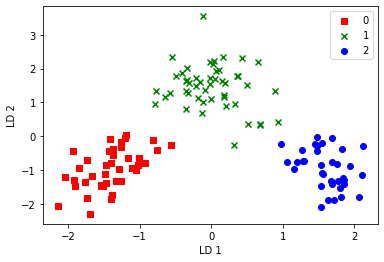

In [24]:
X_train_lda = X_train_std.dot(w)

color = ['r','g','b']
markers = ['s','x','o']

for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_lda[y_train==l,0],X_train_lda[y_train==l,1],c=c,label=l,marker=m)
    
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='best')
plt.show()

Come si vede ora i dati sono facilmente separabili

### Analisi LDA con sklearn

Quello fatto prima è ottimo per capire il funzionamento ma ora possiamo utilizzare sklearn per per validarne il funzionamento.

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
Xtrain_lda = lda.fit_transform(X_train_std, y_train)

Vediamo come il sistema di regressione logistica si comporta su quel dataset

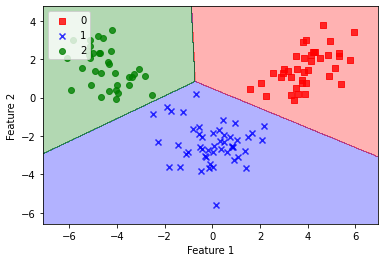

In [26]:
lr = LogisticRegression()
lr.fit(Xtrain_lda,y_train)

dataset.plot_decision_region(Xtrain_lda,y_train,lr)

Osservando il grafico vediamo come le classi risultino ben separate. Proviamo a visualizzare il comportamento nel dataset di test.

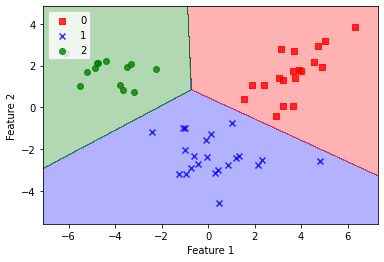

In [27]:
Xtest_lda = lda.transform(X_test_std)

dataset.plot_decision_region(Xtest_lda,y_test,lr)

Vediamo come il comportamento sia ottimo anche nella fase di test.

## Manifold Learning

Abbiamo visto come l'analisi PCA può essere utilizzata per ridurre la dimensionalità del dataset che vogliamo utilizzare, il tutto preservando le informazioni essenziali per la nostra ricerca.

L'analisi PCA è semplice da implementare ma non da buoni risultati se all'interno dei dati ci sono relazioni non lineari.
Per indirizzare questa mancanza possiamo rivolgerci ad una classe di metodi non supervisionati che cerca di descrivere il dato in una dimensionalità più bassa.

Per immaginare questa metodologia possiamo immaginare un foglio di carta (un oggetto bidimensionale), che vive nel nostro mondo tridimensionale. Noi possiamo arrotolarlo nelle sue due dimensioni, nel gergo del manifold embeddings possiamo pensare al foglio arrotolato come ad un embeddings nel mondo tridimensionale.

Una semplice rotazione del pezzo di carta non cambia la sua natura bidimensionale nel mondo tridimensionale, mentre se pieghiamo il pezzetto di carta o appallotoliamo il foglio avremo ancora una entità bidimensionale ma incorporata in uno spazio tridimensionale con una operazione non lineare.

Gli algoritmi di apprendimento manifold cercano fondamentalmente di apprendere la natura bidimensionale del foglio anche se è appallotolato fino a riempire uno spazio tridimensionale.

In questa parte andremo ad analizzare una serie di metodi per il manifold learning e andremo nello specifico delle seguenti metodologie:

* Ridimensionamento Multidimensionale (MDS)
* Embeddings lineare locale (LLE)
* Isometrics Mapping (IsoMap)

Cominciamo con il preparare il nostro dataset, costruiamo ad esempio il nostro foglio di carta bidimensionale

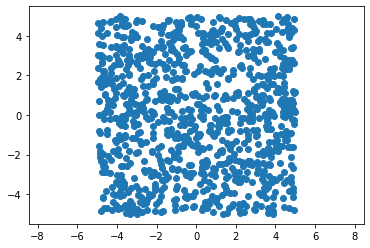

In [28]:
num_samples = 1000

a = 5 # upper bound
b = -5 # lower bound

# Random coordinates [b,a) uniform distributed
y = (b - a) *  np.random.random_sample((num_samples,)) + a # generate random y
x = (b - a) *  np.random.random_sample((num_samples,)) + a # generate random x

X =np.zeros((num_samples,2))
X[:,0] = x
X[:,1] = y

plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

### Multidimensional Scaling

Guardando dataset come questo vediamo che se anche ruotiamo il dataset esso rimane fondamentalmente sempre lo stesso.
Proviamo a fare un esempio pratico di rotazione andando a calcolare la matrice di rotazione.

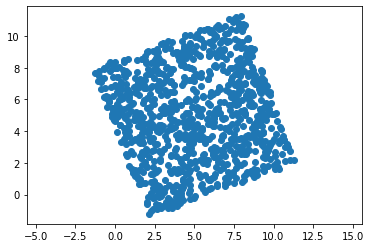

In [29]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1])
plt.axis('equal');

Quello che è fondamentale in questo caso è la distanza di ogni punto nel dataset rispetto agli altri, un metodo semplice per calcolarla e la matrice delle distanze, per ogni $N$ punti andiamo a costruire una matrice $N \times N$ dove $(i,j)$ rappresenta la distanza tra i e j

In [30]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X)
D.shape

(1000, 1000)

Come promesso per 100 punti andiamo ad ottenere una matrice 100 * 100 che può essere visualizzata nel seguente modo:

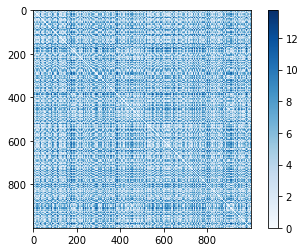

In [31]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

se costruiamo la stessa matrice per X2 il dataset ruotato, otterremo lo stesso risultato

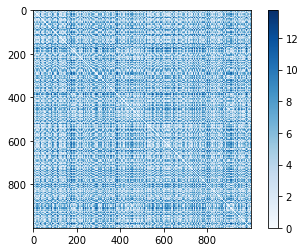

In [32]:
D2 = pairwise_distances(X2)

plt.imshow(D2, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [33]:
np.allclose(D, D2)

True

La riga sopra è la dimostrazione del grafico visuale, e del fatto che questo tipo di costruzioni sono indipendenti dalla rotazione, ma questo tipo di costruzione è difficile da seguire abbiamo perso qualsiasi riferimento al nostro foglio.

Inoltre calcolare questo tipo di matrice è pittosto semplice ma tornare alla rappresentazione x,y non è per nulla banale, ma questo è ciò che fa l'algorimo multiscaling.

Data una matrice di distanze tra i punti recupera una rappresentazione a coordinate del dato.
Vediamo come funziona la trasformazione della matrice di distanze D utilizzando il parametro `precomputed` che dice alla funzione che stiamo lavorando sulle matrice di distanza

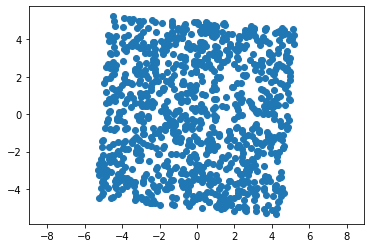

In [34]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed')
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1])
plt.axis('equal');

L'algoritmo recupera una delle possibili matrici utilizzando la matrice delle distance.

### Mds 

L'utilità del sistema viene utile quando pensiamo al fatto che la matrice delle distanze può essere calcolata anche in uno spazio a N dimensioni, per esempio potremmo proiettare il nostro foglio in uno spazio tridimensionale con la funzione qui sotto

In [35]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

Andiamo a visualizzare il risultato

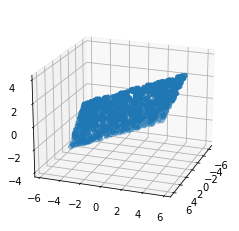

In [36]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2])
ax.view_init(azim=20, elev=20)

Potremmo ora chiederci se il nostro stimatore `MDS` possa attraverso la matrice delle distanze calcolare il foglio originale nello spazio a due dimensioni.

Andiamo a scoprirlo subito, con l'esempio sottostante

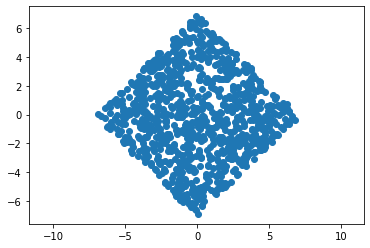

In [37]:
model = MDS(n_components=2)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1])
plt.axis('equal');

Questo è quello che essenzialmente fa un estimatore Manifold, cerca di ricostruire una rappresentazione a bassa dimensionalità che preservi certe relazioni nei dati, nel caso del modello MDS la quantità preservata è la distanza tra i punti.

## Embeddings non lineare

Fino ad ora abbiamo lavorato con trasformazioni lineari ovvero rotazioni o traslazioni e scalature, qui l'algoritmo visto prima si comporta bene ma non è detto che queste trasformazioni siano lineari, ad esempio proviamo ad eseguire la funzione qui otto sul nostro dataset.

In [38]:
def make_s_curve(X):
    t = (X[:, 0]) * 0.1 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_s_curve(X)

Questa è ancora una trasformazione che porta il nostro foglio in uno spazio tridimensionale ma vediamo come.

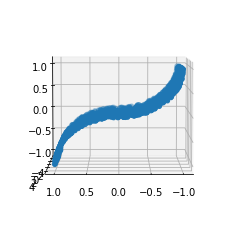

In [39]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2]);

ax.view_init(azim=90, elev=5)

Come vedete ora la trasformazione è molto più complicata, abbiamo una specie di s. Se proviamo ad applicare il metodo MDS vedremo che non saremo più in grado di recuperare il foglio originale in quanto abbiamo perso la relazione originale tra i dati

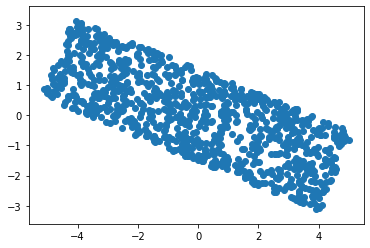

In [40]:
from sklearn.manifold import MDS
model = MDS(n_components=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1])
plt.axis('equal');

Come possiamo provare a mitigare il problema? Facciamo un passo indietro, la fonte del problema è che il sistema MDS cerca di mantenere le distanze anche per i punti lontani del embeddings ma cosa succede se limitassimo questo vincolo solo ai punti più vicini ? Avremmo un risultato pù vicino a quello che vogliamo.

Questo è quello che fa il metodo `LocallyLinearEmbedding` invece di preservare la distanza di tutti i punti si concentra sui `n_neighbors` più vicini.

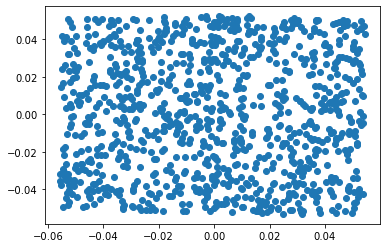

In [41]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1])

Come potete vedere il risultato è ancora un po distorto ma come si può vedere molti pattern originali sono preservati.

## Alcuni ragionamenti sui sistemi Manifold

Sebbene queste dimostrazioni siano convincenti, in pratica le tecniche di Manifold Learning tendono ad essere utilizzate soltanto per la visualizzazione qualitativa dei dati ad alta dimensionalità.

Qui sotto alcuni ragionamenti che comparano i metodi manifold con PCA:

* Nei sistemi manifold non esiste un buon sistema per la gestione dei dati mancanti.
* Nell'apprendimento manifold la presenza di rumore nei dati può compromettere il sistema, nel sistema PCA questo viene filtrato naturalmente dal sistema stesso.
* Per ottenere un buon risultato con il sistema manifold bisogna scegliere bene il numero dei vicini, al contrario il sistema PCA non obbliga a questa scelta.
* Nel sistema manifold scegliere il numero di dimensionalità minima è molto difficile, al contrario con PCA abbiamo tutte le informazioni necessarie.
* Nei sistemi manifold il risulato delle dimensioni compresse non è sempre chiaro, nei sistemi PCA invece le scelte fatte sono molto chiare.
* I sistemi manifold sono generalmente molto pesanti dal punto di vista computazionale, questo non vale per i sistemi PCA

Ne esce che l'unico chiaro vantaggio è che questi sistemi preservano le relazioni quando non ci sono combinazioni lineari, per questo questi sistemi vengono usato solo dopo aver usato le tecniche lineari viste prima.

Qui alcuni consigli su come usare queste tecniche:

I sistemi `LocallyLinearEmbedding` e le sue variati tendono a funzionare bene su problemi giocattolo, tipo la curva ad s vista prima. Nei problemi reali di solito le tecniche `IsoMap` funzionano molto meglio pacchetto `sklearn.manifold.Isomap`, mentre per i dati che si possono dividere bene in sottoinsiemi le tecniche t-SNE tendono a fornire i migliori risutati pacchetto `sklearn.manifold.TSNE`.

### Esempio di Manifold sul dataset faces

Un posto dove provare gli algoritmi manifold sono i dataset con alta dimensionalità, questi sistemi vengono usati per capire le relazioni che ci sono nei dati.
Un buon posto per iniziare potrebbe essere il dataset Labeled Faces in the Wild che contiene i visi delle persone.

In [42]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

Come vedete abbiamo 2370 immagini con ognuna 2914 pixels. In altre parole abbiamo uno spazio dimensionale di 2914 features.
Visualizziamo alcune immagini per vedere con cosa stiamo lavorando:

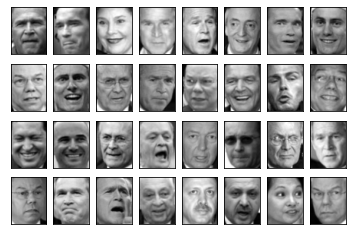

In [43]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Analizziamo il possibile embeddings dei dati al fine di apprendere le relazioni tra i dati.
Un buon punto di partenza è l'analisi PCA ed esaminare il rapporto di varianza spiegato, questo ci da una idea di quante feature servono per descrivere il dato.

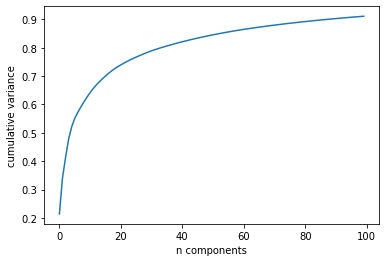

In [47]:
from sklearn.decomposition import PCA
model = PCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

Come vediamo dal dato 100 feature descrivono il 90% della varianza del dato, questo è il caso in cui i metodi manifold possono venirci in aiuto. 
Calcoliamo l'embeddings isomap con lo stesso sistema visto prima.

In [49]:
from sklearn.manifold import Isomap
X_embedded_iso = Isomap(n_components=2).fit_transform(faces.data)
X_embedded_iso.shape

(2370, 2)

ed eseguiamo gli stessi passaggi con il metodo TSNE

In [51]:
from sklearn.manifold import TSNE

X_embedded_tsne = TSNE(n_components=2).fit_transform(faces.data)
X_embedded_tsne.shape

(2370, 2)

Ora che abbiamo le nostre proiezioni possiamo costruire una funzione che si occupi di visualizzare in un grafico le immagini e verifcare come vengono divise

In [52]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Vediamo il risultato

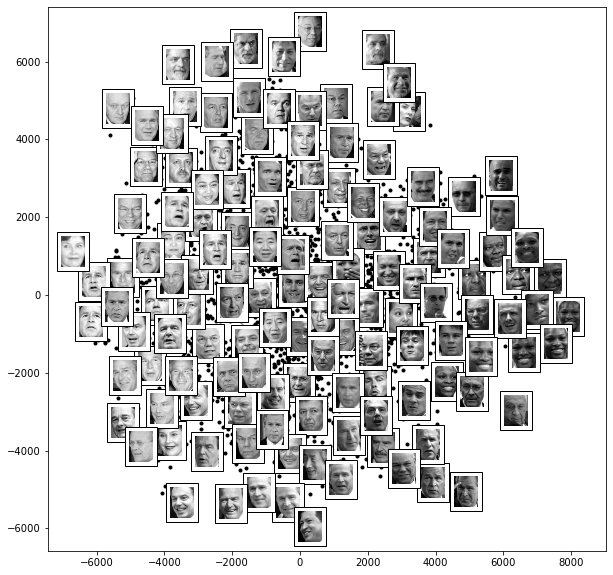

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data, model=Isomap(n_components=2),images=faces.images[:, ::2, ::2])

E lo stesso per il metodo TSNE

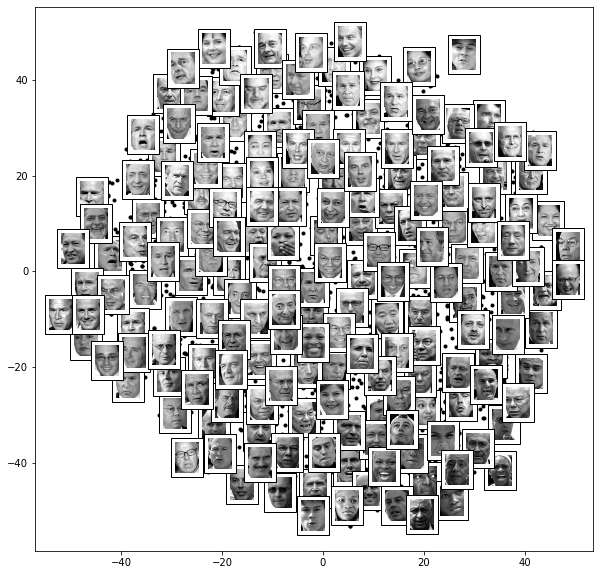

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data, model=TSNE(n_components=2),images=faces.images[:, ::2, ::2])

Specialmente nelle isomappe vediamo che le due feature più importanti la chiarezza o l'oscurità della foto e l'orientamento del viso.